<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Variational Autoencoders (VAE)

In this lab excercise you will train a Variational AuteEncoder to learn the distribution of MNIST data. You will explore the latent space and learn how to generate new samples.

No need for GPUs today, training should take ~1 minute on a Colab CPU.

Some notation:
* $x \in \{0,1\}^{28\times 28}$ are images (binarized MNIST, for simplicity)
* $z \in \mathbb{R}^d$ are latent vectors.
* $p_\text{prior}(z)$ is a *prior* distribution over the latent space. We'll use the standard multivariate gaussian distribution $\mathcal{N}(0,\mathbb{I}^d)$.
* $E(x)$ is the encoder that accepts images $x$ as input and outputs a distribution over the latent space.
  * The produced distribution is denoted $q_\phi(z|x)$.
  * We'll use the multivariate gaussian $\mathcal{N}(\mu, \text{diag}(\sigma^2))$
  * $\phi$ are weights of the encoder network.
  * $\mu=\mu_{\phi}(x)$ and $\sigma=\sigma_{\phi}(x) \in \mathbb{R}^d$ is what the encoder network outputs.
* $D(z)$ is the decoder that accepts samples $z$ from the latent distribution and outputs a distribution over images.
  * The produced distribution is denoted $p_\theta(x|z)$.
  * We'll use the product distribution of independent per-pixel Bernoulli variables $\prod_{i,j \in [28\times 28]} \text{Bern}(p_{i,j}(z))$.
  * $\theta$ are weights of the decoder network.
  * $p_{i,j}(z) \in [0,1]$ are the $28 \times 28$ outputs of the decoder network.

The loss, for a sample $x$ from the dataset, is:

$$ELBO(x) = \mathbb{E}_{z \sim q(z|x)} \big[\log p_\theta(x|z)\big] - D_{KL}\big(q_\phi(z | x) || p_\text{prior}(z)\big).$$

The first term is trained by sampling $z$ using the reparametrization trick so that gradients flow through $\mathbb{E}_{z \sim q(z|x)}$.

The second term can be calculated analytically in our setup and is equal to:

$$ D_{KL}\big( \mathcal{N}(\mu, \text{diag}(\sigma^2))\ ||\ \mathcal{N}(0, \mathbb{I}^d) \big) = \sum_{i \in [d]} \frac12 \big(\sigma_i^2  - \log(\sigma_i^2) + \mu_i^2 - 1 \big).$$

## Tasks
1. Run the pipeline and verify that VAE is training and generating decent digit representation.
2. Implement the `encode_and_sample()` method in the VariationalAutoEncoder class, which accepts an image $x$ as input and outputs samples from the posterior distribution $q_\phi(z|x)$.
3. Implement the `decode_and_sample()` method in the VariationalAutoEncoder class, which accepts either samples $z_0$ or a number of samples to take from the prior distribution, and outputs sampled images $x$:
    * If samples are not provided, take a sample $z_0 \sim p(z)$ from the prior distribution.
    * Run the decoder to obtain parameters $D_\theta(z_0) = (p_{i,j}) \in [0,1]^{28 \times 28}$  describing the distribution $p_\theta(x|z_0)$.
    * Sample a reconstruction from that distribution: $x_0 \sim p_\theta(x|z_0)$.
5. Explore the latent space. For each class (digit), encode a sample (≥100) of images $x$ of that class and visualize e.g. the first two parameters $\mu_0, \mu_1$ describing the distribution $q_\phi(z|x)$. Visualize samples as scatter plot. Remember to color points according to image classes! Can you think of better ways to visualize it?
6. Sample two points $z_0, z_1$ from the prior distribution $p(z)$. Perform an interpolation, i.e. visualize how samples change based on points from the segment between $z_0$ and $z_1$.
    Can you think of other things to interpolate between?

## Imports

In [1]:
from pathlib import Path
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.accelerator
import torchvision.datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import v2

## Datasets and dataloaders

In [2]:
batch_size = 1024
test_batch_size = 1000

latent_size = 5  # Dimensionality of the latent space (size of z vector).

seed = 1
torch.manual_seed(seed)

In [3]:
# Check for CUDA / MPS (Apple) / XPU (Intel) / ... accelerator.
device = (
    torch.accelerator.current_accelerator(check_available=True)
    or torch.device("cpu")  #
)
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


In [4]:
class RandomBinarize:
    """Input: tensor probabilities, output: samples (0 or 1), same shape, dtype bool."""

    def __call__(self, sample: torch.Tensor) -> torch.Tensor:
        return torch.bernoulli(sample).to(torch.bool)


data_dir = Path("./data")
transform = v2.Compose(
    [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), RandomBinarize()]
)
inverse_transform = v2.Compose(
    [
        v2.ToDtype(torch.float32),
        v2.ToDtype(torch.uint8, scale=True),
        v2.ToPILImage(),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    "../data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST("../data", train=False, transform=transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=use_accel,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=use_accel,
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [5]:
def visualize_data(
    images: np.ndarray | Tensor,  # (B, C, H, W)
    labels: np.ndarray | Tensor | None = None,  # (B,)
    figsize: tuple[int, int] = (30, 30),
):
    B, C, H, W = images.shape
    fig, axes = plt.subplots(1, B, figsize=figsize, squeeze=True, layout="constrained")
    if B == 1:
        axes = [axes]

    for i in range(0, B):
        if C == 3:
            axes[i].imshow(inverse_transform(images[i]))
        else:
            axes[i].imshow(inverse_transform(images[i].squeeze()), cmap="gray")
        if labels is not None:
            axes[i].set_title(labels[i].item(), fontsize=28)
        axes[i].axis("off")
    plt.show()

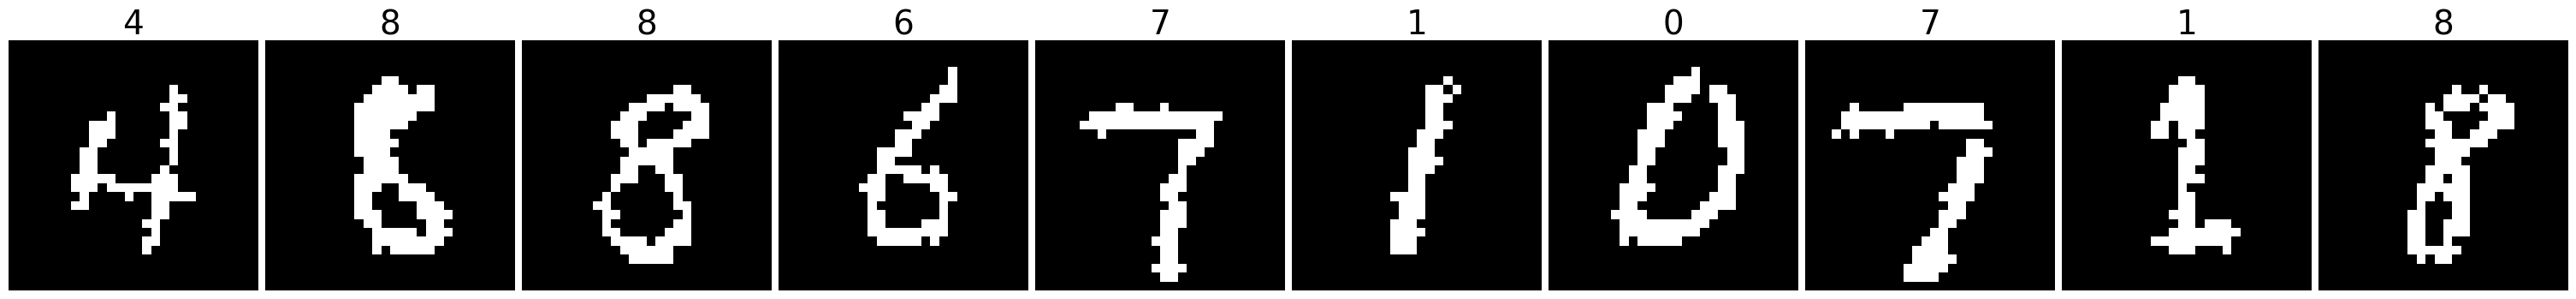

In [6]:
real_images, real_labels = next(iter(train_loader))
visualize_data(real_images[:10], real_labels[:10])

## Models (encoder & decoder)

In [7]:
class EncoderOutput(NamedTuple):
    mu: Tensor  # mean of encoder output distribution, shape (B, latent_size)
    sigma: Tensor  # standard deviations, shape (B, latent_size)


class Encoder(nn.Module):
    def __init__(self, linear_sizes: list[int], latent_size: int) -> None:
        super().__init__()
        self.layers = nn.Sequential()
        for in_size, out_size in zip(linear_sizes[:-1], linear_sizes[1:], strict=True):
            self.layers.append(nn.Linear(in_size, out_size))
            self.layers.append(nn.BatchNorm1d(out_size))
            self.layers.append(nn.ReLU())

        self.last_layer_mu = nn.Linear(linear_sizes[-1], latent_size)
        self.last_layer_sigma = nn.Linear(linear_sizes[-1], latent_size)

    def forward(self, x: Tensor) -> EncoderOutput:
        """Input x shape: (B, C, H, W) dtype bool, output: see EncoderOutput."""
        x = self.layers(x.flatten(start_dim=1).to(torch.float32))
        mu = self.last_layer_mu(x)
        logsigma = self.last_layer_sigma(x)
        sigma = torch.log(1 + torch.exp(logsigma))  # softplus, make sure sigma > 0.
        return EncoderOutput(mu=mu, sigma=sigma)

In [8]:
class Decoder(nn.Module):
    def __init__(
        self, linear_sizes: list[int], output_size: tuple[int, int] = (28, 28)
    ) -> None:
        super().__init__()
        self.output_size = output_size

        self.layers = nn.Sequential()
        for in_layer_size, out_layer_size in zip(linear_sizes, linear_sizes[1:]):
            self.layers.append(nn.Linear(in_layer_size, out_layer_size))
            self.layers.append(nn.BatchNorm1d(out_layer_size))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(linear_sizes[-1], output_size[0] * output_size[1]))
        self.layers.append(nn.Sigmoid())

    def forward(self, z: Tensor) -> Tensor:
        """Input: z of shape (B, latent_size), output: Bernoulli probabilities 0..1 of shape (B, 1, H, W)."""
        x = self.layers(z)
        return x.view(-1, 1, *self.output_size)

In [9]:
class VariationalAutoEncoderOutput(NamedTuple):
    mu: Tensor  # (B, latent_size) means of z
    sigma: Tensor  # (B, latent_size) standard deviations of z
    p: Tensor  # (B, 1, H, W)  Bernoulli probabilities for reconstructed x.


class VariationalAutoEncoder(nn.Module):
    def __init__(
        self,
        encoder_linear_sizes: list[int],
        latent_size: int,
        decoder_linear_sizes: list[int],
        output_size: tuple[int, int] = (28, 28),
    ):
        super().__init__()
        self.encoder = Encoder(encoder_linear_sizes, latent_size)
        self.decoder = Decoder(decoder_linear_sizes, output_size)
        self.latent_size = latent_size
        self.output_size = output_size

    def forward(self, x: Tensor) -> Tensor:
        encoded = self.encoder(x)

        eps = torch.normal(0.0, 1.0, size=encoded.mu.shape).to(device)
        z = (eps * encoded.sigma) + encoded.mu

        decoded = self.decoder(z)
        return VariationalAutoEncoderOutput(
            mu=encoded.mu, sigma=encoded.sigma, p=decoded
        )

    def encode_and_sample(self, x: Tensor) -> Tensor:
        """
        Input: x of shape (B, 1, H, W), output: z of shape (B, latent_size).
        Output should be sampled in a way that allows for backpropagation.
        """

        # we have the mean of z  mu, the standard dev of z sigma,
        # TODO: Task 2.
        Z = self.encoder(x)
        eps = torch.normal(0.0, 1.0, size=Z.mu.shape).to(device)
        z = (eps * Z.sigma) + Z.mu
        print("encoding:)")
        return z

    def decode_and_sample(self, latents: Tensor | int) -> torch.Tensor:
        """Input: latents of shape (B, latent_size) or int (number of samples to generate from prior)."""
        # TODO: Task 3.
        if isinstance(latents, int):
          latents = torch.normal(0.0, 1.0, size=(latents,latent_size),device=device)
          # now we call decode on this
        xNew = self.decoder(latents)
        print("decoding:)")
        return xNew

## Training

In [10]:
def KL_gaussian_loss(mu: Tensor, sigma: Tensor) -> Tensor:
    """
    Input: mu and sigma of shape (B, latent_size), output: (B,).

    The output is the KL divergence between N(mu, diag(sigma^2)) and N(0, 1).
    """
    return torch.sum(
        ((sigma * sigma) - (2 * torch.log(sigma)) + (mu * mu) - 1) / 2, dim=1
    )


def ELBO(x: Tensor, vae_output: VariationalAutoEncoderOutput) -> Tensor:
    """Input: x and VAE output. Returns: ELBO loss (scalar, mean over batch)."""
    # Note that we sum over factors of factorial distribution, but take the mean over the batch.
    BCE = (
        F.binary_cross_entropy(vae_output.p, x.to(torch.float32), reduction="sum")
        / x.shape[0]
    )
    KL = KL_gaussian_loss(vae_output.mu, vae_output.sigma).mean()
    return BCE + KL

In [11]:
def train(
    model: nn.Module,
    device: torch.device,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    epoch: int,
    log_interval: int = 10,
) -> None:
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        vae_output = model(data)
        loss = ELBO(data, vae_output)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} "
                + f"[image {batch_idx * len(data)}/{len(train_loader.dataset)} ({batch_idx / len(train_loader):.0%})]\t"
                + f"Loss: {loss.item():.1f}"
            )


def test(model: nn.Module, device: torch.device, test_loader: DataLoader) -> None:
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            vae_output = model(data)
            loss = ELBO(data, vae_output)
            test_loss += loss * data.shape[0]

    test_loss /= len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.1f}\n")

In [12]:
vae = VariationalAutoEncoder(
    [28 * 28, 500, 350], latent_size, [latent_size, 350, 500], (28, 28)
)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=5e-3)

In [13]:
epochs = 2
for epoch in range(1, epochs + 1):
    train(vae, device, train_loader, optimizer, epoch)
    test(vae, device, test_loader)

Train Epoch: 1 [image 0/60000 (0%)]	Loss: 563.1
Train Epoch: 1 [image 10240/60000 (17%)]	Loss: 183.8
Train Epoch: 1 [image 20480/60000 (34%)]	Loss: 160.3
Train Epoch: 1 [image 30720/60000 (51%)]	Loss: 149.4
Train Epoch: 1 [image 40960/60000 (68%)]	Loss: 142.9
Train Epoch: 1 [image 51200/60000 (85%)]	Loss: 142.0

Test set: Average loss: 138.1

Train Epoch: 2 [image 0/60000 (0%)]	Loss: 136.6
Train Epoch: 2 [image 10240/60000 (17%)]	Loss: 139.6
Train Epoch: 2 [image 20480/60000 (34%)]	Loss: 132.0
Train Epoch: 2 [image 30720/60000 (51%)]	Loss: 130.4
Train Epoch: 2 [image 40960/60000 (68%)]	Loss: 132.8
Train Epoch: 2 [image 51200/60000 (85%)]	Loss: 129.7

Test set: Average loss: 129.5



## Results
### Reconstruction

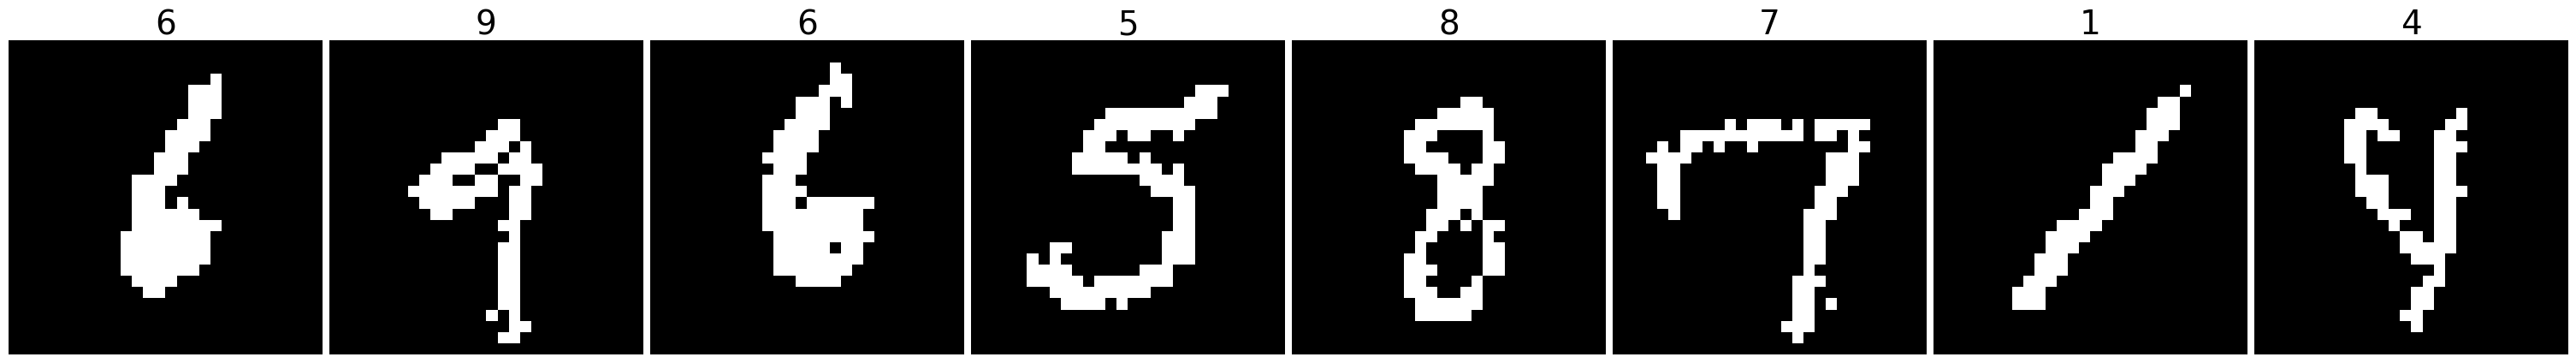

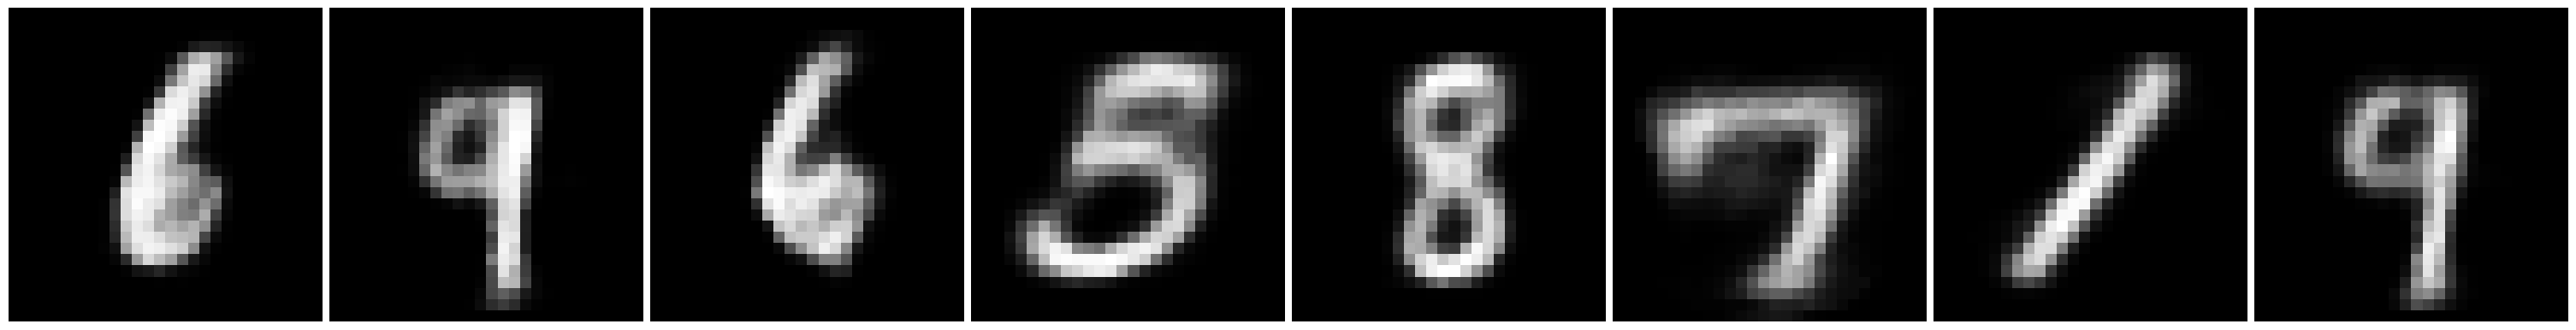

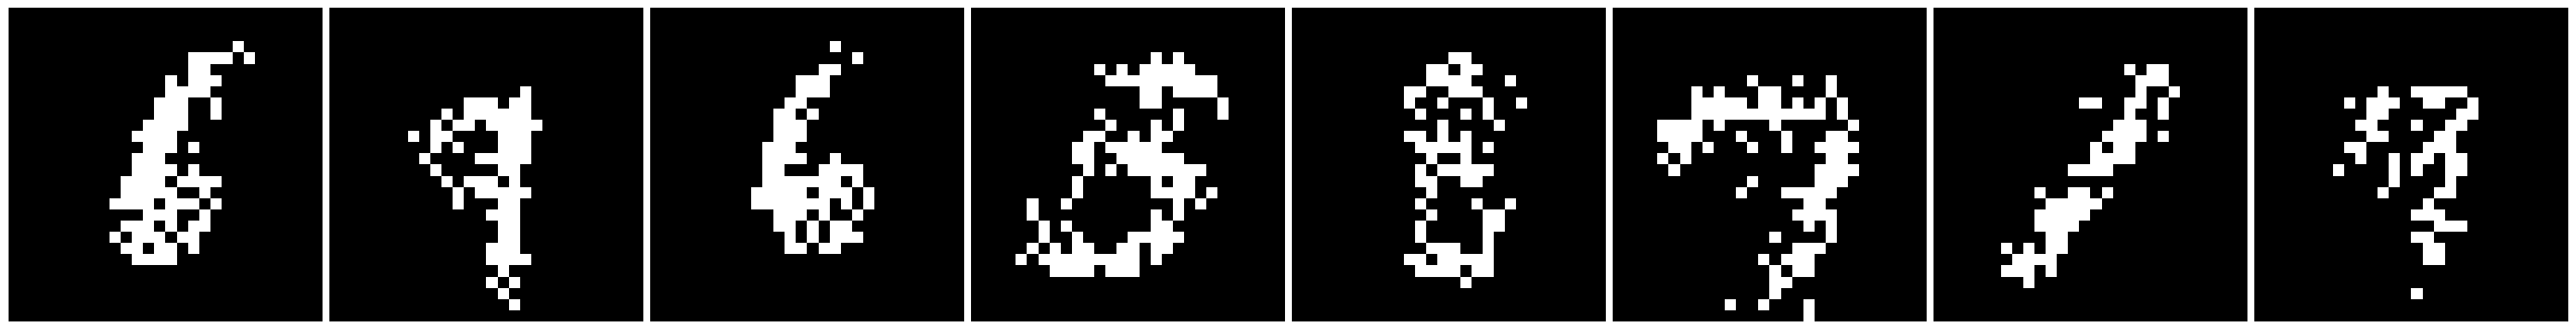

In [14]:
def example_reconstruction():
    real_images, real_labels = next(iter(train_loader))
    real_images, real_labels = real_images[:8], real_labels[:8]
    vae.eval()
    vae_output = vae(real_images.to(device))
    visualize_data(real_images.to(float).detach().cpu().numpy(), real_labels.cpu().numpy())
    visualize_data(vae_output.p.detach().cpu().numpy())
    x = torch.bernoulli(vae_output.p)
    visualize_data(x.detach().cpu().numpy())


example_reconstruction()

### Visualization of latent space (TODO)

#### Scatterplot of encodings of real images (colored by class (digit))
Hints:
* Use `cmap="Paired"` to get colors that are easy to distinguish.
* Use `ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")` to show a legend with all 10 classes.

#### Interpolation in latent space

encoding:)
decoding:)


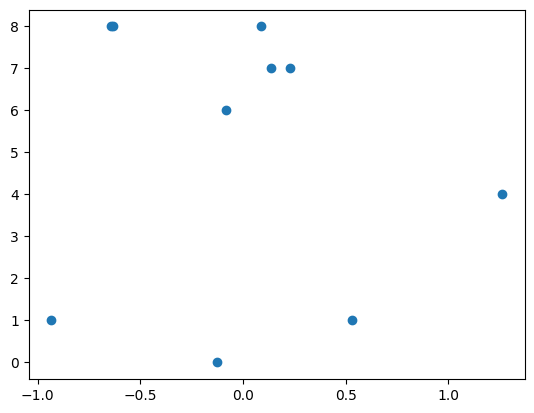

In [29]:
# %%capture
import matplotlib.animation as animation
import matplotlib.axes as ax
from IPython.display import HTML
import matplotlib.pyplot as plt



# TODO
# generate images
latents = vae.encode_and_sample(real_images[0:10].to(device)) # 10 encodings
images = vae.decode_and_sample(latents) # B x latentSize


plt.scatter(latents[:,0].cpu().detach().numpy(),real_labels[0:10])
plt.show
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(inverse_transform(img.squeeze()), cmap="gray", animated=True)]
    for img in images
]
ani = animation.ArtistAnimation(fig, ims, interval=30, repeat_delay=1000, blit=True)
plt.close()
HTML(ani.to_jshtml())